<center><div style="font-size: 24px; font-weight: bold; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-bottom: 15px;">
    Import the Libraries
</div></center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from torch.cuda import is_available

from tqdm.notebook import tqdm

<center><div style="font-size: 24px; font-weight: bold; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-bottom: 15px;">
    Import the Datasets
</div></center>

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')
submission_df = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')

<center><div style="font-size: 24px; font-weight: bold; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-bottom: 15px;">
    EDA and Data Preprocessing
</div></center>

In [3]:
train_df.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [4]:
test_df.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [5]:
save_train_preds = train_df[['id']]
test_preds = test_df[['id']]

In [6]:
submission_df.head()

,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [7]:
print("train_df shape:", train_df.shape)
print("train_df shape after dropping duplicates:", train_df.drop_duplicates().shape)
print("test_df shape:", test_df.shape)
print("submission_df shape:", submission_df.shape)

train_df shape: (3116945, 22)
train_df shape after dropping duplicates: (3116945, 22)
test_df shape: (2077964, 21)
submission_df shape: (2077964, 2)


In [8]:
train_df.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [9]:
# # Find the features with more than 65 percent null values
# threshold = 0.65
# columns_to_drop = train_df.columns[train_df.isnull().mean() > threshold].tolist()
# columns_to_drop += ['id']
# print(columns_to_drop)

In [10]:
# # Drop the unnecessary columns
# train_df.drop(columns_to_drop, axis = 1, inplace = True)
# test_df.drop(columns_to_drop, axis = 1, inplace = True)

In [11]:
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (3116945, 22)
test_df shape: (2077964, 21)


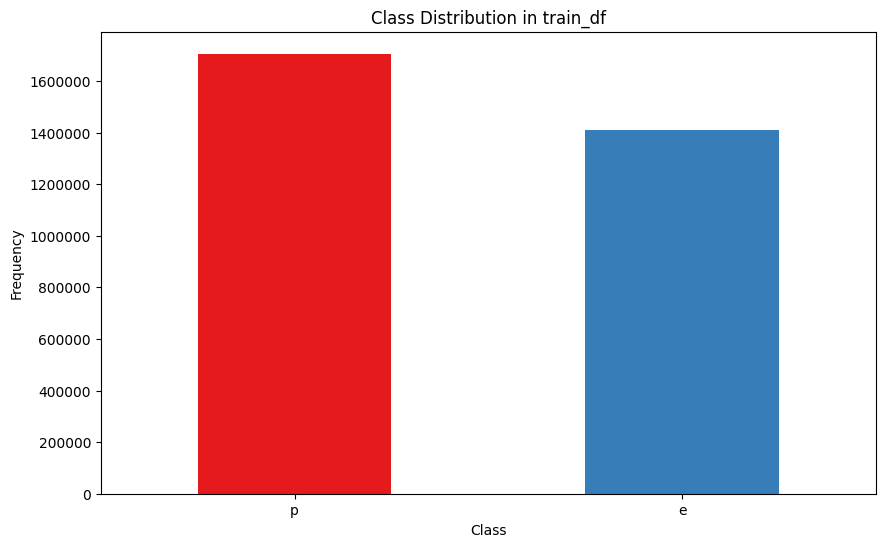

In [12]:
# Get the value counts
class_counts = train_df['class'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
colors = sns.color_palette('Set1', len(class_counts))
class_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution in train_df')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [13]:
# Label encoding
replace_map = {'e': 0, 'p': 1}

train_df['class'] = train_df['class'].replace(replace_map)

/tmp/ipykernel_18/931270434.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['class'] = train_df['class'].replace(replace_map)


In [14]:
# Class distribution
train_df['class'].value_counts()

class
1    1705396
0    1411549
Name: count, dtype: int64

In [15]:
# Find the categorical variables with two unique values
binary_categorical_columns = [col for col in train_df.select_dtypes(include=['object', 'category']).columns 
                              if train_df[col].nunique() == 2]

print(binary_categorical_columns)

[]


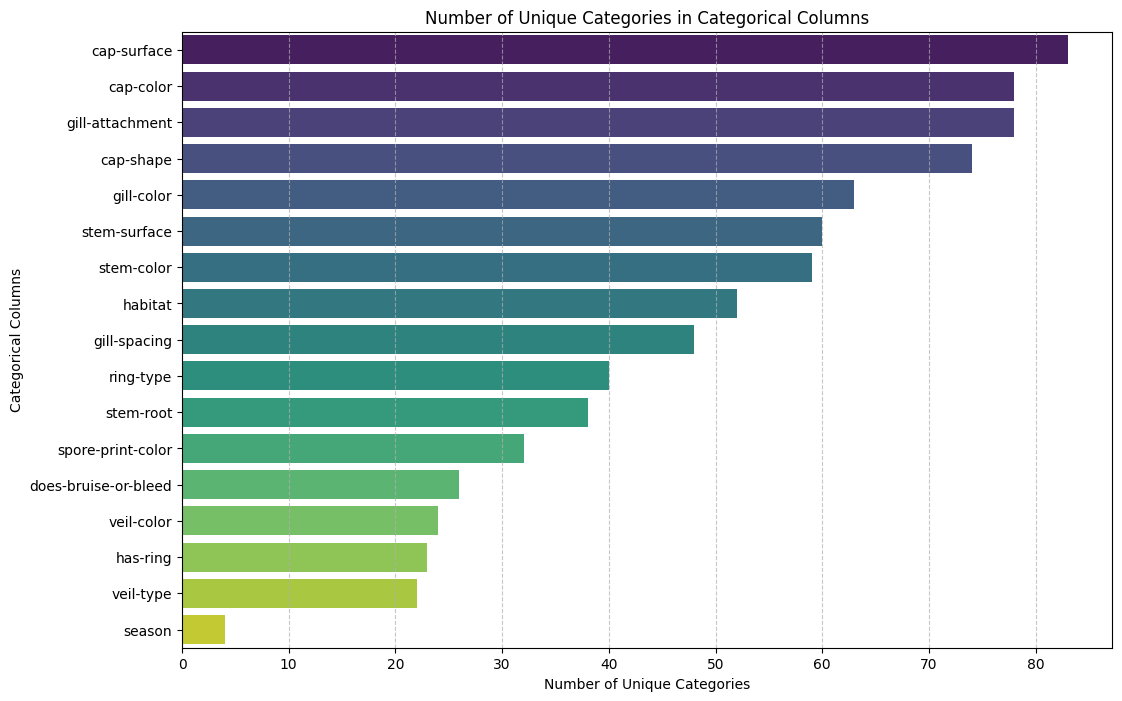

In [16]:
# Get categorical columns
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Count unique categories in each categorical column
unique_categories_count = {col: train_df[col].nunique() for col in categorical_columns}

# Create a data frame for plotting
unique_categories_df = pd.DataFrame(list(unique_categories_count.items()), columns=['Column', 'Unique Categories'])

# Sort the data frame by 'Unique Categories' in descending order
unique_categories_df.sort_values(by='Unique Categories', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Unique Categories', y='Column', data=unique_categories_df, palette='viridis')
plt.title('Number of Unique Categories in Categorical Columns')
plt.xlabel('Number of Unique Categories')
plt.ylabel('Categorical Columns')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# Identify categorical variables based on data types
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert string values to lowercase
train_df[categorical_columns] = train_df[categorical_columns].map(lambda x: x.lower() if isinstance(x, str) else x)
test_df[categorical_columns] = test_df[categorical_columns].map(lambda x: x.lower() if isinstance(x, str) else x)

In [18]:
# Convert the data types to 'category'
train_df[categorical_columns] = train_df[categorical_columns].astype('category')
test_df[categorical_columns] = test_df[categorical_columns].astype('category')

<center>
    <div style="font-size: 18px; font-weight: bold; color: #8e44ad; border-bottom: 2px solid #f39c12; padding-bottom: 5px; margin-bottom: 15px;">
        Split the Training Set into Features and Target
    </div>
</center>

In [19]:
# Split the training set into features and target
X = train_df.drop('class', axis = 1)
y = train_df['class']

<center><div style="font-size: 24px; font-weight: bold; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-bottom: 15px;">
    Training and Validating the Model
</div></center>

In [20]:
# Number of folds for cross-validation
n_folds = 5

# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=142)

# Initialize lists to store scores and models
train_auc_scores = []
valid_auc_scores = []
models = []

# Initialize array to store test predictions
oof_predictions = np.zeros(len(train_df))
test_predictions = np.zeros(len(test_df))

# LightGBM parameters
if is_available():
    # If GPU is available
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 142,
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
        'device': 'gpu',
        'gpu_use_dp': True
    }
else:
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': 142,
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'verbose': -1,
    }


In [21]:
# Perform cross-validation
for fold, (train_idx, valid_idx) in enumerate(tqdm(skf.split(X, y), total=skf.get_n_splits(), desc="Cross-Validation"), 1):
    print(f"Fold {fold}")
    
    # Split the data
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=5000,
        valid_sets=[train_data, valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=500), lgb.log_evaluation(100)]
    )
    
    # Make predictions
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    
    oof_predictions[valid_idx] = valid_preds
    
    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_preds)
    valid_auc = roc_auc_score(y_valid, valid_preds)
    
    # Store scores and model
    train_auc_scores.append(train_auc)
    valid_auc_scores.append(valid_auc)
    # models.append(model)
    
    # Make predictions on the test set
    test_predictions += model.predict(test_df, num_iteration = model.best_iteration)
    
    print()

Cross-Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Fold 1
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.996169	valid_1's auc: 0.996202
[200]	training's auc: 0.99668	valid_1's auc: 0.99662
[300]	training's auc: 0.996966	valid_1's auc: 0.996798
[400]	training's auc: 0.997217	valid_1's auc: 0.996904
[500]	training's auc: 0.997412	valid_1's auc: 0.99698
[600]	training's auc: 0.997585	valid_1's auc: 0.99704
[700]	training's auc: 0.997724	valid_1's auc: 0.997077
[800]	training's auc: 0.997847	valid_1's auc: 0.997107
[900]	training's auc: 0.997946	valid_1's auc: 0.997115
[1000]	training's auc: 0.998052	valid_1's auc: 0.997121
[1100]	training's auc: 0.998146	valid_1's auc: 0.997131
[1200]	training's auc: 0.998237	valid_1's auc: 0.997136
[1300]	training's auc: 0.99832	valid_1's auc: 0.997141
[1400]	training's auc: 0.998396	valid_1's auc: 0.99714
[1500]	training's auc: 0.998474	valid_1's auc: 0.997141
[1600]	training's auc: 0.998547	valid_1's auc: 0.99714
[1700]	training's auc: 0.998609	valid_1's auc: 0.99

In [22]:
print(save_train_preds.shape, oof_predictions.shape)
print(test_preds.shape, test_predictions.shape)

oof_predictions

(3116945, 1) (3116945,)
(2077964, 1) (2077964,)


array([0.00399104, 0.99644838, 0.00575589, ..., 0.99873113, 0.00608013,
       0.99589418])

In [23]:
test_predictions = test_predictions / skf.get_n_splits()

test_predictions

array([0.00238629, 0.99671963, 0.99228844, ..., 0.99555645, 0.00183076,
       0.00794023])

In [24]:
name = 'preds_lgb_5fold_seed142_pub02'
save_train_preds[name] = oof_predictions
save_train_preds = save_train_preds[name]
save_train_preds.to_csv(f'train_{name}.csv', index=False)

/tmp/ipykernel_18/172853746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  save_train_preds[name] = oof_predictions


In [25]:
test_preds[name] = test_predictions
test_preds = test_preds[name]
test_preds.to_csv(f'test_{name}.csv', index=False)

/tmp/ipykernel_18/1552682993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_preds[name] = test_predictions


In [26]:
# Calculate mean of scores
mean_train_auc = np.mean(train_auc_scores)
mean_valid_auc = np.mean(valid_auc_scores)

print(f"Mean Train AUC: {mean_train_auc:.4f}")
print(f"Mean Valid AUC: {mean_valid_auc:.4f}")

Mean Train AUC: 0.9985
Mean Valid AUC: 0.9972


<center>
    <div style="font-size: 18px; font-weight: bold; color: #8e44ad; border-bottom: 2px solid #f39c12; padding-bottom: 5px; margin-bottom: 15px;">
        Predictions for the Test Data
    </div>
</center>

In [27]:
test_predictions = test_predictions > 0.5
submission_df['class'] = test_predictions.astype(int)

In [28]:
# Label Decoding
replace_map = {0: 'e', 1: 'p'}

submission_df['class'] = submission_df['class'].replace(replace_map)
submission_df.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


<center><div style="font-size: 24px; font-weight: bold; color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-bottom: 15px;">
    Save Predictions
</div></center>

In [29]:
# Save predictions to csv
submission_df.to_csv('submission.csv', index=False)
print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
